In [1]:
# IMPORTO I DATI PER VOTTIGNASCO
import os
import numpy as np

# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_normalization_factors_std_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_mean_path     = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)
vott_target_test_std    = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean   = np.load(v_test_normalization_factors_mean_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))
print(vott_target_test_std)
print(vott_target_test_mean)

105
105
105
0.7535387605163045
4.426558334608545


In [2]:
import tensorflow as tf
#from tensorflow.keras import layers, activations, callbacks, models
import numpy as np
import pickle
import os
from keras.models import load_model
from skimage.transform import resize
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sys

# Se vuoi abilitare il dropout a runtime
mc_dropout = True

# Definizione della classe personalizzata doprout_custom
class doprout_custom(tf.keras.layers.SpatialDropout1D):
    def call(self, inputs, training=None):
        if mc_dropout:
            return super().call(inputs, training=True)
        else:
            return super().call(inputs, training=False)

# Percorso della directory su Cineca
base_dir = os.path.join(os.environ['WORK'], "Water_Resources/rise-video/trained_models/seq2val/Vottignasco")
lstm_suffix = 'time_dist_LSTM'

vott_lstm_models = []

def extract_index(filename):
    """Funzione per estrarre l'indice finale dal nome del file."""
    return int(filename.split('_LSTM_')[-1].split('.')[0])

# Trova tutti i file .keras nella cartella e li aggiunge alla lista
for filename in os.listdir(base_dir):
    if lstm_suffix in filename and filename.endswith(".keras"):
        vott_lstm_models.append(os.path.join(base_dir, filename))

# Ordina i modelli in base all'indice finale
vott_lstm_models = sorted(vott_lstm_models, key=lambda x: extract_index(os.path.basename(x)))

# Lista per i modelli caricati
vott_lstm_models_loaded = []

for i, model_lstm_path in enumerate(vott_lstm_models[:10]):  # Prendo i primi 10 modelli ordinati
    #print(f"Caricamento del modello LSTM {i+1}: {model_lstm_path}")

    # Carico il modello con la classe custom
    model = load_model(model_lstm_path, custom_objects={"doprout_custom": doprout_custom})

    # Aggiungo il modello alla lista
    vott_lstm_models_loaded.append(model)

print(vott_lstm_models_loaded)

2025-03-07 20:10:22.466025: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 20:10:23.884084: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-07 20:10:27.195829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 20:10:27.198819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 20:10:27.706854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

[<keras.src.engine.functional.Functional object at 0x7f8f1c55aef0>, <keras.src.engine.functional.Functional object at 0x7f8f1617a8f0>, <keras.src.engine.functional.Functional object at 0x7f8f15f00c70>, <keras.src.engine.functional.Functional object at 0x7f8f15f60f40>, <keras.src.engine.functional.Functional object at 0x7f8f15fb2950>, <keras.src.engine.functional.Functional object at 0x7f8f15dcb910>, <keras.src.engine.functional.Functional object at 0x7f8f15e8a800>, <keras.src.engine.functional.Functional object at 0x7f8f15eb5300>, <keras.src.engine.functional.Functional object at 0x7f8f15d36aa0>, <keras.src.engine.functional.Functional object at 0x7f8f15d368c0>]


In [3]:
def ensemble_predict(models, images, x3_exp, batch_size=1000):
    # Assicuriamoci che images sia una lista
    if not isinstance(images, list):
        images = [images]

    len_x3 = len(images)

    # Convertiamo x3_exp in un tensore replicato per ogni immagine
    x3_exp_tensor = tf.convert_to_tensor(x3_exp, dtype=tf.float32)

    # Lista per raccogliere le predizioni finali
    final_preds = []

    # Processamento a batch
    for i in range(0, len_x3, batch_size):
        batch_images = images[i:i + batch_size]
        batch_len = len(batch_images)

        # Conversione batch in tensori
        Y_test = tf.stack([tf.convert_to_tensor(img, dtype=tf.float32) for img in batch_images])
        Y_test_x3 = tf.tile(tf.expand_dims(x3_exp_tensor, axis=0), [batch_len, 1, 1])

        # Raccoglie le predizioni di tutti i modelli per il batch corrente
        batch_preds = []

        for model in models:
            preds = model.predict([Y_test, Y_test_x3], verbose=0)
            batch_preds.append(preds)

        # Converte le predizioni del batch in un tensore e calcola la media
        batch_preds_tensor = tf.stack(batch_preds)
        mean_batch_preds = tf.reduce_mean(batch_preds_tensor, axis=0)

        # Aggiunge le predizioni del batch alla lista finale
        final_preds.extend(mean_batch_preds.numpy())

    return np.array(final_preds)

In [4]:
models = vott_lstm_models_loaded

instance = copy.deepcopy(vottignasco_test_image[0])
x3_instance = copy.deepcopy(vottignasco_test_OHE[0])

# Predizione su Istanza Originale
pred_original = ensemble_predict(models, instance, x3_instance)

print(f"Normalizated Prediction: {pred_original}")
print(f"Denormalizated Prediction: {pred_original + vott_target_test_mean * vott_target_test_std}")

Normalizated Prediction: [[0.17893372]]
Denormalizated Prediction: [[3.5145168]]


### *Test*

In [5]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_rise_masks_2d(N, input_size, seed, **kwargs):
    """
    Genera N maschere RISE per un'immagine di dimensioni HxW.

    Parametri:
    - N: numero di maschere
    - input_size: (H,W) dimensioni dell'immagine originale
    - h, w: dimensioni delle maschere a bassa risoluzione
    - p: probabilità di attivazione dei pixel nella maschera binaria iniziale

    Ritorna:
    - masks: array di shape (N, H, W) contenente le maschere normalizzate.
    """

    h  = kwargs.get("h", 2)
    w = kwargs.get("w", 2)
    p = kwargs.get("p", 0.5)

    np.random.seed(seed)

    masks = []
    H,W = input_size
    CH, CW = H // h, W // w  # Fattore di upscaling

    for _ in range(N):
        # 1. Generazione della maschera binaria iniziale (h x w)
        small_mask = np.random.rand(h, w) < p

        up_size_h = (h+1) * CH
        up_size_w = (w+1) * CW

        # 2. Upsampling bilineare alla dimensione (H + CH, W + CW
        upsampled_mask = cv2.resize(small_mask.astype(np.float32),
                                    (up_size_w, up_size_h), interpolation=cv2.INTER_LINEAR)
        
        #print(upsampled_mask.shape)
        
        # 3. Crop casuale della regione H x W
        x_offset = np.random.randint(0, (up_size_h - H) + 1)
        y_offset = np.random.randint(0, (up_size_w - W) + 1)
        final_mask = upsampled_mask[x_offset:x_offset + H, y_offset:y_offset + W] 

        #print(final_mask.shape)

        masks.append(final_mask)

    masks = np.array(masks)  # Converte la lista in array NumPy
    masks = masks[~(masks == 0).all(axis=(1, 2))]  # Filtro maschere vuote
    masks = masks[~(masks == 1.0).all(axis=(1, 2))]  # Filtro maschere con tutti 1.0


    return np.array(masks)


def multiplicative_uniform_noise_onechannel(images, masks, channel, **kwargs):
    std_zero_value = kwargs.get("std_zero_value", -0.6486319166678826)

    masked = []

    # Itero su tutte le N maschere generate
    for mask in masks:
        masked_images = copy.deepcopy(images)  # Copia profonda delle immagini originali

        # Applica la perturbazione solo al canale specificato
        masked_images[..., channel] = (
            masked_images[..., channel] * mask + (1 - mask) * std_zero_value)

        masked.append(masked_images)

    return masked

def ensemble_predict(models, images, x3_exp, batch_size=1000):
    # Assicuriamoci che images sia una lista
    if not isinstance(images, list):
        images = [images]

    len_x3 = len(images)

    # Convertiamo x3_exp in un tensore replicato per ogni immagine
    x3_exp_tensor = tf.convert_to_tensor(x3_exp, dtype=tf.float32)

    # Lista per raccogliere le predizioni finali
    final_preds = []

    # Processamento a batch
    for i in range(0, len_x3, batch_size):
        batch_images = images[i:i + batch_size]
        batch_len = len(batch_images)

        # Conversione batch in tensori
        Y_test = tf.stack([tf.convert_to_tensor(img, dtype=tf.float32) for img in batch_images])
        Y_test_x3 = tf.tile(tf.expand_dims(x3_exp_tensor, axis=0), [batch_len, 1, 1])

        # Raccoglie le predizioni di tutti i modelli per il batch corrente
        batch_preds = []

        for model in models:
            preds = model.predict([Y_test, Y_test_x3], verbose=0)
            batch_preds.append(preds)

        # Converte le predizioni del batch in un tensore e calcola la media
        batch_preds_tensor = tf.stack(batch_preds)
        mean_batch_preds = tf.reduce_mean(batch_preds_tensor, axis=0)

        # Aggiunge le predizioni del batch alla lista finale
        final_preds.extend(mean_batch_preds.numpy())

    return np.array(final_preds)

"""#### ***Saliency Map***"""

# Modifica della funzione per calcolare la mappa di salienza introducendo anche -> E[M] cioè il valore atteso delle Maschere

def calculate_saliency_map_ev_masks(weights_array, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.

    :param weights_array: Array di predizioni (pesi delle maschere).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []

    H, W = masks.shape[1], masks.shape[2]
    for j in range(len(masks)):
        sal_j = weights_array[j] * np.abs(masks[j])
        sal.append(sal_j.reshape(-1, H, W))

    # Rimuovere le dimensioni extra per fare np.mean lungo axis=0. masks ha shape (N,5,8,1)
    masks_squeezed = np.squeeze(np.abs(masks))
    # Ora calcola la media lungo l'asse 0
    ev_masks = np.mean(masks_squeezed, axis=0)

    sal = (1/ev_masks) * np.mean(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)

    return np.squeeze(sal)

In [98]:
nr_instance = 0

N = 1000
h,w = 2,4
p = 0.5

seed = 42
channel_prec = 0

instance    = copy.deepcopy(vottignasco_test_image[nr_instance])
x3_instance = copy.deepcopy(vottignasco_test_OHE[nr_instance])

input_size = (instance.shape[1], instance.shape[2])

masks = generate_rise_masks_2d(N, input_size, seed, h=h,w=w,p=p)
perturbed_instances = multiplicative_uniform_noise_onechannel(instance, masks, channel_prec)

# Predizione su Istanza Originale
pred_original = ensemble_predict(models, instance, x3_instance)
# Predizioni su Istanze Perturbate
preds_masked = ensemble_predict(models, perturbed_instances, x3_instance)

In [99]:
H = 390.0

denorm_pred_original = pred_original * vott_target_test_std + vott_target_test_mean
denorm_preds_masked  = [pred_masked * vott_target_test_std + vott_target_test_mean for pred_masked in preds_masked]
print(f"Predizione Originale Denormalizzata: {denorm_pred_original}")
print(f"Predizione Originale Denormalizzata: {denorm_preds_masked}")

denormalized_H_pred_original = H - denorm_pred_original
denormalized_H_preds_masked  = [H - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]

print("New Original Prediction: ", denormalized_H_pred_original)
print("New Preds Masked: ", denormalized_H_preds_masked)

Predizione Originale Denormalizzata: [[4.5717955]]
Predizione Originale Denormalizzata: [array([5.4651237], dtype=float32), array([5.220489], dtype=float32), array([5.484682], dtype=float32), array([5.615119], dtype=float32), array([5.409722], dtype=float32), array([5.895591], dtype=float32), array([4.724251], dtype=float32), array([5.422682], dtype=float32), array([5.8513107], dtype=float32), array([5.9380903], dtype=float32), array([4.7915936], dtype=float32), array([5.057845], dtype=float32), array([4.9880753], dtype=float32), array([5.3392196], dtype=float32), array([5.5182204], dtype=float32), array([5.5115285], dtype=float32), array([5.3308444], dtype=float32), array([5.733299], dtype=float32), array([5.5375195], dtype=float32), array([5.936622], dtype=float32), array([5.832841], dtype=float32), array([5.9422464], dtype=float32), array([5.5487356], dtype=float32), array([5.0867753], dtype=float32), array([5.7108912], dtype=float32), array([5.4683437], dtype=float32), array([5.661

In [89]:
# Differenza tra predizione originale e perturbata
diff_pred = [denormalized_H_pred_original - denorm_H_pred for denorm_H_pred in denormalized_H_preds_masked]
weights = np.concatenate(diff_pred, axis=0)

print(weights)

[[0.9058533 ]
 [0.6548462 ]
 [0.86621094]
 ...
 [0.67544556]
 [0.64282227]
 [0.90075684]]


In [90]:
def calculate_saliency_map_ev_masks(weights_array, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.

    :param weights_array: Array di predizioni (pesi delle maschere).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []

    H, W = masks.shape[1], masks.shape[2]
    for j in range(len(masks)):
        sal_j = weights_array[j] * np.abs(masks[j])
        sal.append(sal_j.reshape(-1, H, W))

    # Rimuovere le dimensioni extra per fare np.mean lungo axis=0. masks ha shape (N,5,8,1)
    masks_squeezed = np.squeeze(np.abs(masks))
    # Ora calcola la media lungo l'asse 0
    ev_masks = np.mean(masks_squeezed, axis=0)

    sal = (1/ev_masks) * np.mean(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)

    return np.squeeze(sal)

In [91]:
sal_map_0 = calculate_saliency_map_ev_masks(weights, masks)

In [92]:
sal_map_0

array([[0.87745816, 0.8482282 , 0.8086232 , 0.78453517, 0.79308873,
        0.8153597 , 0.8328817 , 0.83981067],
       [0.8735851 , 0.8440246 , 0.7999487 , 0.7709883 , 0.7777465 ,
        0.80384076, 0.82746285, 0.8381686 ],
       [0.86620003, 0.8376502 , 0.7924886 , 0.76161045, 0.76811063,
        0.7998968 , 0.8312786 , 0.845423  ],
       [0.8588217 , 0.8313381 , 0.7851055 , 0.75222975, 0.7583434 ,
        0.7959014 , 0.83511156, 0.8526821 ],
       [0.8552301 , 0.8290957 , 0.78614473, 0.75625515, 0.76414233,
        0.80368316, 0.84432197, 0.861467  ]], dtype=float32)

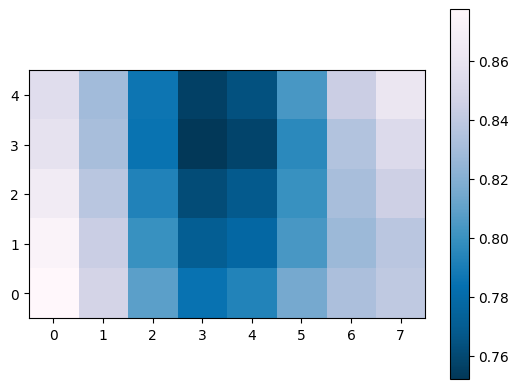

In [93]:
plt.imshow(sal_map_0, cmap="PuBu_r", origin="lower")
plt.colorbar()

In [94]:
def plot_insertion_curve(total_errors, auc, title="Insertion Metric Curve"):
    """
    Plotta la curva di metrica di insertion con l'errore medio quadratico.

    :param total_errors: Lista dei valori dell'errore per ogni frazione di pixel inseriti.
    :param auc: Valore dell'Area Under Curve (AUC) calcolato.
    :param title: Titolo del grafico (default: "Insertion Metric Curve").
    """

    # Nuovo asse X normalizzato tra 0 e 1
    x = np.linspace(0, 1, len(total_errors))

    # Plot della curva dell'errore e dell'area sotto la curva (AUC)
    plt.figure(figsize=(7, 5))
    plt.plot(x, total_errors, marker='o', linestyle='-', color='blue')

    # Pallini blu sui punti della curva
    plt.scatter(x, total_errors, color='blue', zorder=3)

    # Area sotto la curva
    plt.fill_between(x, total_errors, color='skyblue', alpha=0.4)

    # Testo "Error curve" in alto a dx con font più piccolo
    plt.legend(['Error curve'], loc='upper right', fontsize=9)

    # Testo AUC appena sotto "Error curve"
    plt.text(x[-1] - 0.02, max(total_errors) * 0.9,
             f'AUC: {auc:.2f}',
             horizontalalignment='right',
             fontsize=8,
             bbox=dict(facecolor='white', alpha=0.5))

    # Etichette assi
    plt.xlabel('Fraction of pixels inserted')
    plt.ylabel('Mean Squared Error')

    # Titolo del grafico
    plt.title(title)

    # Mostra il grafico
    plt.show()


def plot_deletion_curve(total_errors, auc, title="Deletion Metric Curve"):
    """
    Plotta la curva della metrica di deletion con l'errore medio quadratico.

    :param total_errors: Lista dei valori dell'errore per ogni frazione di pixel rimossi.
    :param auc: Valore dell'Area Under Curve (AUC) calcolato.
    :param title: Titolo del grafico (default: "Deletion Metric Curve").
    """

    # Normalizzazione dell'asse X tra 0 e 1
    x = np.linspace(0, 1, len(total_errors))

    # Creazione del plot
    plt.figure(figsize=(7,5))
    plt.plot(x, total_errors, marker='o', linestyle='-', color='red')

    # Pallini rossi sui punti della curva
    plt.scatter(x, total_errors, color='red', zorder=3)

    # Area sotto la curva
    plt.fill_between(x, total_errors, color='lightcoral', alpha=0.4)

    # Testo "Error curve" in alto a sx con font più piccolo
    plt.legend(['Error curve'], loc='upper left', fontsize=9)

    # Testo AUC appena sotto "Error curve"
    plt.text(x[0] + 0.01, max(total_errors) * 0.88,
             f'AUC: {auc:.2f}',
             horizontalalignment='left',
             fontsize=8,
             bbox=dict(facecolor='white', alpha=0.5))

    # Etichette degli assi
    plt.xlabel('Fraction of pixels removed')
    plt.ylabel('Mean Squared Error')

    # Titolo del grafico
    plt.title(title)

    # Mostra il grafico
    plt.show()


def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)


# Restituisce n-esimo percentile dei pixel più importanti delle mappa di salienza data in input
def get_top_n_pixels(saliency_map, n):
    # Appiattisci la mappa di salienza
    flat_saliency = saliency_map.flatten()
    # Ordina gli indici degli elementi in ordine decrescente di salienza
    sorted_indices = np.argsort(flat_saliency)[::-1]

    # Calcola il numero di colonne della mappa di salienza
    num_cols = saliency_map.shape[1]

    top_pixels = []
    for i in range(n):
        idx = sorted_indices[i]
        row, col = divmod(idx, num_cols)
        top_pixels.append((row, col))

    return top_pixels

"""##### ***Insertion***"""

def update_instance_with_pixels(current_instance, original_instance, x,y):
    """
    Aggiorna l'immagine inserendo i pixel più importanti.

    :param current_instance: Istanza corrente.
    :param original_instance: Istanza originale.
    :param x: coordinata x del pixel da inserire
    :param y: coordinata y del pixel da inserire
    :return: Istanza aggiornata con il superpixel.
    """
    new_current_instance = current_instance.copy()
    new_current_instance[:, x, y, 0] = original_instance[:, x, y, 0]

    return new_current_instance


def insertion(model, original_instance, x3_instance, sorted_per_importance_pixels_index, initial_blurred_instance, original_prediction):
    """
    Calcola la metrica di inserimento per una spiegazione data.

    :param model: Black-box.
    :param original_instance: Istanza originale.
    :param sorted_per_importance_pixels_index: Lista di liste di tutti i superpixel per importanza
    :param initial_blurred_images: Immagine iniziale con tutti i pixel a zero.
    :return: Lista degli errori ad ogni passo di inserimento.
    """

    # Lista per memorizzare le istanze a cui aggiungo pixel mano a mano. Inizializzata con istanza iniziale blurrata
    insertion_images = [initial_blurred_instance]

    # Predizione sull'immagine iniziale (tutti i pixel a zero)
    I_prime = copy.deepcopy(initial_blurred_instance)

    # Aggiungere gradualmente i pixel (per ogni frame) più importanti. Ottengo una lista con tutte le img con i pixel aggiunti in maniera graduale
    for x,y in sorted_per_importance_pixels_index:
        I_prime = update_instance_with_pixels(I_prime, original_instance, x,y)
        insertion_images.append(I_prime)

    insertion_images = [img.astype(np.float32) for img in insertion_images]
    # Calcolo le predizioni sulle istanze a cui ho aggiunto i pixel in maniera graduale
    new_predictions = ensemble_predict(model, insertion_images, x3_instance)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]

    # Rispetto ad ogni suddetta predizione, calcolo il MSE rispetto la pred sull'istanza originaria (come da test-set). Ignora la prima che è sull'img blurrata originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions[1:]]

    initial_error = mean_squared_error(original_prediction, denormalized_H_new_predictions[0])
    print(f"Initial Prediction with Blurred Instance. Prediction: {denormalized_H_new_predictions[0]}, error: {initial_error}")
    only_inserted_pixel_new_predictions = denormalized_H_new_predictions[1:]

    for nr_pixel, error in enumerate(errors):
      print(f"Inserted Pixel: {sorted_per_importance_pixels_index[nr_pixel]}. Prediction: {only_inserted_pixel_new_predictions[nr_pixel]}, error: {error}")

    total_errors = [initial_error] + errors # Errore iniziale + errori su tutti i pixel inseriti

    # # Nuovo asse X
    x = np.linspace(0, 1, len(total_errors))
    # Calcolo dell'AUC con il nuovo asse x
    auc = calculate_auc(x, total_errors)
    print(f"Area under the curve (AUC): {auc}")
    return total_errors,auc

def update_image_by_removing_pixels(current_instance, x, y, std_zero_value=-0.6486319166678826):
    """
    Aggiorna l'immagine rimuovendo i pixel x,y indicati.

    :param current_instance: istanza corrente.
    :param x: coordinata x del pixel da rimuovere
    :param y: coordinata y del pixel da rimuovere
    :return: Istanza aggiornata con x,y rimossi su tutti time-step.
    """
    new_instance = copy.deepcopy(current_instance)
    new_instance[:, x, y, 0] = std_zero_value # Imposta i pixel a zero normalizzato per Prec
    return new_instance

def deletion(models, original_instance, x3_instance, sorted_per_importance_pixels_index, original_prediction):
    """
    Calcola la metrica di rimozione per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_instance: Immagine originale.
    :param x3_instance: Codifica one-hot per la previsione.
    :param sorted_per_importance_pixels_index: Indici dei pixel in ordine di importanza.
    :return: Lista degli errori, auc ad ogni passo di rimozione.
    """
    # Lista per memorizzare le img a cui elimino gradualmente i pixels (per ogni time-step)
    deletion_images = []

    # Inizializzazione
    I_prime = copy.deepcopy(original_instance)

    # Aggiungere gradualmente i pixel (per ogni frame) più importanti. Ottengo una lista con tutte le img con i pixel rimossi
    for x, y in sorted_per_importance_pixels_index:
        I_prime = update_image_by_removing_pixels(I_prime, x, y)
        deletion_images.append(I_prime)

    # Calcolo della predizione su tutte le img a cui ho rimosso gradualmente i pixel
    new_predictions = ensemble_predict(models, deletion_images, x3_instance)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Calcolo del mse rispetto la predizione originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions]

    initial_error = 0.0
    print(f"Initial Prediction with Original Images, prediction: {original_prediction}, error: {initial_error}")
    for nr_pixel, error in enumerate(errors):
        print(f"Removed pixel {sorted_per_importance_pixels_index[nr_pixel]}, new prediction: {denormalized_H_new_predictions[nr_pixel]}, error: {error}")

    total_errors = [initial_error] + errors  # Errore iniziale + errori su tutti i pixel rimossi

    # Normalizzare la frazione di pixel rimossi
    x = np.linspace(0, 1, len(total_errors))
    # Calcolo dell'AUC
    auc = calculate_auc(x, total_errors)

    print(f"Area under the curve (AUC): {auc}")
    return total_errors, auc

In [95]:
std_zero_value = -0.6486319166678826
saliency_map_i = sal_map_0


# Insertion
# Video blurrato da cui partire per l'Insertion. Tutti i pixel di Prec su std_zero_value
initial_blurred_instance = copy.deepcopy(instance)
initial_blurred_instance[:,:,:,channel_prec] = std_zero_value

all_important_pixels = get_top_n_pixels(saliency_map_i, instance.shape[1]*instance.shape[2])[::-1]

original_instance = copy.deepcopy(instance)

original_prediction = ensemble_predict(models, original_instance, x3_instance)
denormalized_H_original_prediction = H - (original_prediction * vott_target_test_std + vott_target_test_mean)

print(f"Original Prediction: {denormalized_H_original_prediction}")
errors_insertion,auc_insertion = insertion(models, original_instance, x3_instance, all_important_pixels, initial_blurred_instance, denormalized_H_original_prediction)

print(f"Errors Insertion: {errors_insertion}")
print(f"AUC Insertion: {auc_insertion}")

Original Prediction: [[385.41104]]
Initial Prediction with Blurred Instance. Prediction: [384.00946], error: 1.9644287824630737
Inserted Pixel: (3, 3). Prediction: [384.2177], error: 1.424033761024475
Inserted Pixel: (4, 3). Prediction: [384.0855], error: 1.7570323944091797
Inserted Pixel: (3, 4). Prediction: [384.14648], error: 1.5991041660308838
Inserted Pixel: (2, 3). Prediction: [384.28482], error: 1.2683730125427246
Inserted Pixel: (4, 4). Prediction: [384.2653], error: 1.3127474784851074
Inserted Pixel: (2, 4). Prediction: [384.27966], error: 1.280016541481018
Inserted Pixel: (1, 3). Prediction: [384.40555], error: 1.0110164880752563
Inserted Pixel: (1, 4). Prediction: [384.49478], error: 0.8395319581031799
Inserted Pixel: (0, 3). Prediction: [384.57736], error: 0.6950210332870483
Inserted Pixel: (3, 2). Prediction: [384.54404], error: 0.7516966462135315
Inserted Pixel: (4, 2). Prediction: [384.67444], error: 0.5425836443901062
Inserted Pixel: (2, 2). Prediction: [384.81], error:

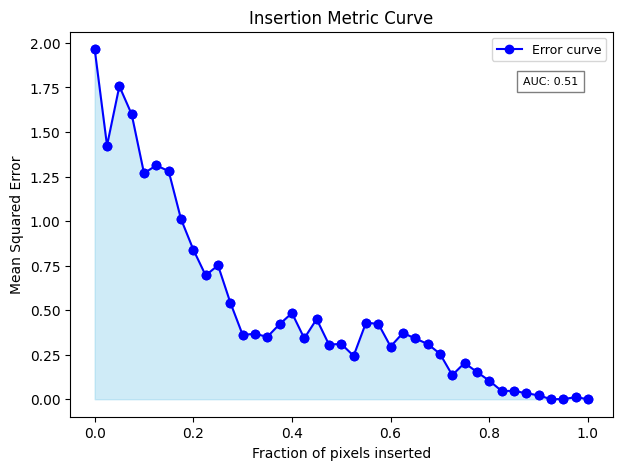

In [96]:
plot_insertion_curve(errors_insertion, auc_insertion)

In [97]:
# Deletion
errors_deletion,auc_deletion = deletion(models, original_instance, x3_instance, all_important_pixels, denormalized_H_original_prediction)
print(f"Errors Deletion: {errors_deletion}")
print(f"AUC Deletion: {auc_deletion}")

Initial Prediction with Original Images, prediction: [[385.41104]], error: 0.0
Removed pixel (3, 3), new prediction: [385.15518], error: 0.06546401977539062
Removed pixel (4, 3), new prediction: [384.96667], error: 0.1974615454673767
Removed pixel (3, 4), new prediction: [384.7919], error: 0.3833351135253906
Removed pixel (2, 3), new prediction: [384.75327], error: 0.43266910314559937
Removed pixel (4, 4), new prediction: [384.8185], error: 0.3510909676551819
Removed pixel (2, 4), new prediction: [384.7728], error: 0.4073562026023865
Removed pixel (1, 3), new prediction: [384.6871], error: 0.5240862369537354
Removed pixel (1, 4), new prediction: [384.63788], error: 0.5977807641029358
Removed pixel (0, 3), new prediction: [384.50433], error: 0.8221189975738525
Removed pixel (3, 2), new prediction: [384.54218], error: 0.7549280524253845
Removed pixel (4, 2), new prediction: [384.50278], error: 0.8249437808990479
Removed pixel (2, 2), new prediction: [384.48926], error: 0.8496847152709961

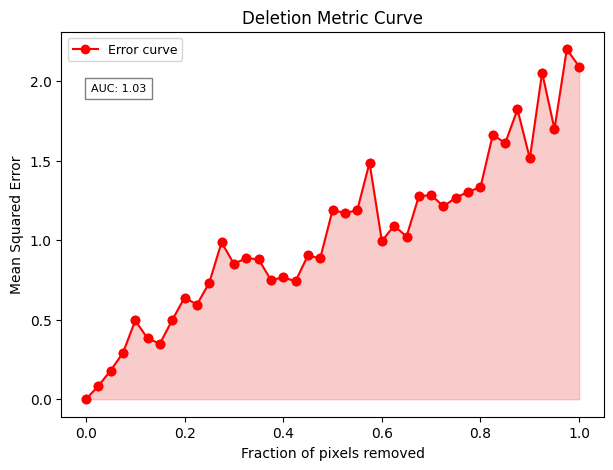

In [84]:
plot_deletion_curve(errors_deletion, auc_deletion)